In [1]:
!pip install timm torch ultralytics dotenv huggingface_hub


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import torch
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import numpy as np
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import requests

load_dotenv()

False

In [5]:
load_dotenv()
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
hugging_face_token = os.getenv('HF_TOKEN') #create a huggingface token and put it in .env file

In [6]:
from huggingface_hub import login
login(token=hugging_face_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


#Testing segmentation yolov11 - ignore this

In [8]:
# model = YOLO("yolo11n-seg.pt")

In [10]:
# import cv2 as cv
# img = cv.imread("dataset/test.jpg")
# results = model(img)[0]
# results.show()  # display to screen
# results.save(filename="result.jpg")
# # cv.imshow("Display window", img)
# k = cv.waitKey(0) # Wait for a keystroke in the window


0: 480x640 18 apples, 155.6ms
Speed: 4.7ms preprocess, 155.6ms inference, 28.7ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
# model_type = "DPT_Large"
# midas = torch.hub.load("intel-isl/MiDaS", model_type)

In [ ]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# midas.to(device)
# midas.eval()

In [ ]:
# custom_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((384, 384)),  # or any size multiple of 32
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])
#
# img = cv2.imread("dataset/test.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# input_tensor = custom_transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")
#
# with torch.no_grad():
#     prediction = midas(input_tensor)
#
# # Resize prediction to original image size
# prediction = torch.nn.functional.interpolate(
#     prediction.unsqueeze(1),
#     size=(448,640),
#     mode="bicubic",
#     align_corners=False
# ).squeeze()
# depth_map = prediction.cpu().numpy()
# plt.imshow(depth_map)

Get fruit items detections

In [7]:
def get_index(results, results_2):
  index = []
  import numpy as np
  array_index = np.zeros(len(results[0]['boxes']), dtype=bool)
  for i in range(len(results_2[0].boxes.xyxy)):
    #segmentation
    x1,y1,x2,y2 = results_2[0].boxes.xyxy[i]
    for y in range(len(results[0]['boxes'])):
      # if array_index[y] == True:
      #   break
      x1_1,y1_1,x2_1,y2_1 = results[0]['boxes'][y]
      if abs(x1-x1_1) < 50 and abs(x2-x2_1) < 50 and abs(y1-y1_1) < 50 and abs(y2-y2_1) < 50:
        index.append(i)
        # array_index[y] = True
      # else:
      #   break
  return index

In [8]:
def draw_image_segmentation(results_2,index):
  img_bgr = results_2[0].orig_img.copy()
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  mask_ids = index

  H, W = img.shape[:2]
  combined_mask = np.zeros((H, W), dtype=np.uint8)

  for idx in mask_ids:
      m = results_2[0].masks.data[idx].cpu().numpy().astype(np.uint8)
      if m.shape != (H, W):
          m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)
      combined_mask = np.logical_or(combined_mask, m)

  overlay = img.copy()
  color = np.array([0, 255, 0], dtype=np.uint8)
  alpha = 0.5
  overlay[combined_mask] = (alpha * color + (1 - alpha) * overlay[combined_mask]).astype(np.uint8)

  plt.imshow(overlay)
  plt.axis("off")
  plt.show()


Load the model to do detection

In [9]:
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model_dec = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [10]:
def show_gd_results(img, results, score_thr=0.25):
    if isinstance(img, str):
        img = Image.open(img).convert("RGB")
    elif isinstance(img, torch.Tensor):
        if img.ndim == 3 and img.shape[0] in (1,3):
            img = img.permute(1,2,0).detach().cpu().numpy()
        else:
            img = img.detach().cpu().numpy()
        img = (img*255).astype(np.uint8) if img.max()<=1 else img.astype(np.uint8)
        img = Image.fromarray(img)
    elif not isinstance(img, Image.Image):
        img = Image.fromarray(img)

    r = results[0] if isinstance(results, (list, tuple)) else results
    boxes  = r["boxes"].detach().cpu().numpy()
    scores = r["scores"].detach().cpu().numpy()
    labels = r.get("labels", r.get("text_labels", []))

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(np.asarray(img))
    for (x1,y1,x2,y2), s, lab in zip(boxes, scores, labels):
        if s < score_thr:
            continue
        ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor='blue'))
        ax.text(x1, max(0, y1-5), f"{lab} {s:.2f}",
                fontsize=9, color="white",
                bbox=dict(facecolor="blue", alpha=0.5, pad=2))
    ax.axis("off")
    plt.show()

# Example:
# show_gd_results(original_pil_image, results, score_thr=0.3)


In [11]:
# image_url = "/content/test.jpg"
def get_detection(image_path, model_dec):
  image = Image.open(image_path).convert("RGB")
  # Check for cats and remote controls
  # VERY important: text queries need to be lowercased + end with a dot
  text = "banana . broccoli . avocado . tomato . onion . apple ."

  inputs = processor(images=image, text=text, return_tensors="pt").to(device)
  with torch.no_grad():
      outputs = model_dec(**inputs)
  results = processor.post_process_grounded_object_detection(
      outputs,
      inputs.input_ids,
      target_sizes=[image.size[::-1]]
  )
  show_gd_results(image, results)
  return results

Crop image

In [12]:
import torch
def get_index_detection(results):
  dic_ind = {"banana" : [], "tomato" : [] , "broccoli" : [], "onion" : [], "apple" : [], "avocado" : []}
  for index in range(len(results[0]['text_labels'])):
    if results[0]['text_labels'][index] not in dic_ind:
      continue
    dic_ind[results[0]['text_labels'][index]].append(index)

  xyxy = torch.zeros((6, 4), dtype= torch.float32)  # 3 rows, 2 columns
  index_arr = 0
  for fruit, index in dic_ind.items():
    x1, y1, x2,y2 = results[0]['boxes'][dic_ind[fruit][0]]
    xyxy[index_arr][0] = x1
    xyxy[index_arr][1] = y1
    xyxy[index_arr][2] = x2
    xyxy[index_arr][3] = y2
    index_arr += 1


  index_arr = 0
  for fruit, index in dic_ind.items():
    for i in index:
      x1, y1, x2,y2 = results[0]['boxes'][i]
      if (x1 < xyxy[index_arr][0]):
        xyxy[index_arr][0] = x1

      if (y1 < xyxy[index_arr][1]):
        xyxy[index_arr][1] = y1

      if (x2 > xyxy[index_arr][2]):
        xyxy[index_arr][2] = x2

      if (y2 > xyxy[index_arr][3]):
        xyxy[index_arr][3] = y2
    index_arr += 1
  return dic_ind,xyxy

In [13]:
def draw_xyxy_on_image(img_path, xyxy, classes, seen=None, out_path=None):
    img = cv2.imread(img_path)
    H, W = img.shape[:2]

    boxes = xyxy.detach().to('cpu').round().to(torch.int64).numpy()

    # optional clamp
    boxes[:, [0,2]] = boxes[:, [0,2]].clip(0, W)
    boxes[:, [1,3]] = boxes[:, [1,3]].clip(0, H)

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        if seen is not None and (not bool(seen[i].item())):
            continue
        if x2 <= x1 or y2 <= y1:
            continue
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        label = classes[i]
        cv2.putText(img, label, (x1, max(0, y1 - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

    if out_path:
        cv2.imwrite(out_path, img)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



In [29]:
def crop_xyxy_regions(img_path, xyxy, classes, seen=None, save_dir="crops", show=True):
    names = []
    crops = []
    img = cv2.imread(img_path)
    H, W = img.shape[:2]
    os.makedirs(save_dir, exist_ok=True)
    boxes = xyxy.detach().to('cpu').round().to(torch.int64).numpy()

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        if seen is not None and not bool(seen[i].item()):
            continue
        if x2 <= x1 or y2 <= y1:
            continue
        x1 = max(0, min(W, x1))
        x2 = max(0, min(W, x2))
        y1 = max(0, min(H, y1))
        y2 = max(0, min(H, y2))

        crop = img[y1:y2, x1:x2]
        filename = f"{classes[i]}_crop.jpg"
        names.append(filename)
        crops.append(crop)

        cv2.imwrite(os.path.join(save_dir, filename), crop)
        print(f"Saved {filename}")

    if show and crops:
        cols = min(3, len(crops))
        rows = (len(crops) + cols - 1) // cols
        plt.figure(figsize=(5*cols, 5*rows))
        for j, crop in enumerate(crops):
            plt.subplot(rows, cols, j+1)
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.title(names[j])
            plt.axis("off")
        plt.show()

    return names, crops


Segmentation the whole image

In [15]:
from ultralytics import SAM

# Load a model
# For SAM=sam_b.pt, SAM2=sam2_b.pt, SAM2.1=sam2.1_b.pt
model = SAM("sam2.1_l.pt")

model.info()  # Display model information (optional)

Model summary: 595 layers, 224,446,642 parameters, 224,446,642 gradients


(595, 224446642, 224446642, 0.0)

In [16]:
# Run inference (image or video)
def get_whole_photo_seg(image_path, model):
  results_2 = model.predict(image_path, conf = 0.1, iou = 1, batch = 10, max_det = 600, rect = False)  # image
  # results = model("https://youtu.be/LNwODJXcvt4")  # video file

  results_2[0].show()  # Display results
  return results_2

Processing the items segmentation

In [17]:
def get_index(results, results_2):
  index = []
  dic_ind = {"banana" : [], "tomato" : [] , "broccoli" : [], "onion" : [], "apple" : [], "avocado" : []}
  import numpy as np
  array_index = np.zeros(len(results[0]['boxes']), dtype=bool)
  for i in range(len(results_2[0].boxes.xyxy)):
    #segmentation
    x1,y1,x2,y2 = results_2[0].boxes.xyxy[i]
    for y in range(len(results[0]['boxes'])):
      # if array_index[y] == True:
      #   break
      x1_1,y1_1,x2_1,y2_1 = results[0]['boxes'][y]
      flag = False
      if abs(x1-x1_1) < 50 and abs(x2-x2_1) < 50 and abs(y1-y1_1) < 50 and abs(y2-y2_1) < 50:
        index.append(i)
        flag = True
      elif (x1_1 > x1) and (x2_1 > x2) and (y1_1 > y1) and (y2_1 > y2):
        index.append(i)
        flag = True

      if flag == True:
        if(results[0]['text_labels'][y] not in dic_ind):
          continue
        dic_ind[results[0]['text_labels'][y]].append(i)
        # array_index[y] = True
      # else:
      #   break
  for k, v in dic_ind.items():
    dic_ind[k] = list(dict.fromkeys(v))
  return index,dic_ind

In [18]:
def draw_image_segmentation(results_2,index):
  img_bgr = results_2[0].orig_img.copy()
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

  mask_ids = index

  H, W = img.shape[:2]
  combined_mask = np.zeros((H, W), dtype=np.uint8)

  for idx in mask_ids:
      m = results_2[0].masks.data[idx].cpu().numpy().astype(np.uint8)
      if m.shape != (H, W):
          m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)
      combined_mask = np.logical_or(combined_mask, m)

  overlay = img.copy()
  color = np.array([0, 255, 0], dtype=np.uint8)
  alpha = 0.5
  overlay[combined_mask] = (alpha * color + (1 - alpha) * overlay[combined_mask]).astype(np.uint8)

  plt.imshow(overlay)
  plt.axis("off")
  plt.show()
  cv2.imwrite("../Captone_AI/dataset/segmentation.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))


Testing function

In [19]:
image_path = "../Captone_AI/dataset/test_1.png"

C:\Users\minhv\anaconda3\Lib\site-packages\transformers\models\grounding_dino\processing_grounding_dino.py:100: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


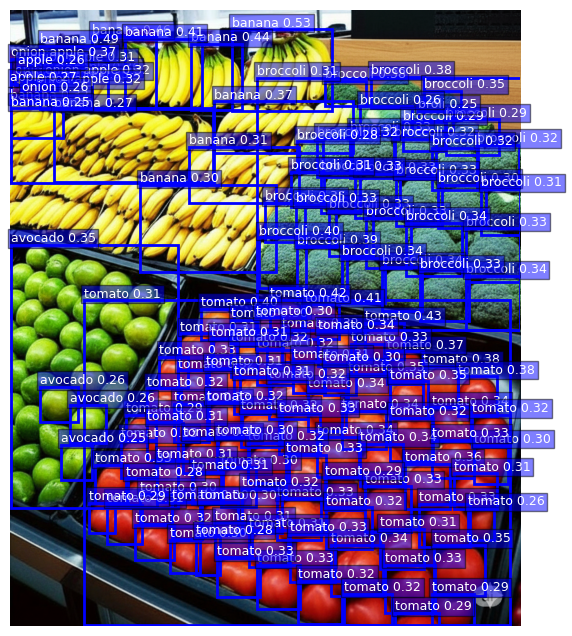

In [20]:
results  = get_detection(image_path, model_dec)

In [21]:
results_2 = get_whole_photo_seg(image_path, model)


image 1/1 C:\Users\minhv\OneDrive\Documents\GitHub\Captone_AI\..\Captone_AI\dataset\test_1.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 138, 1 139, 1 140, 1 141, 1 142, 1 

In [22]:
index,dic_ind  = get_index(results, results_2)

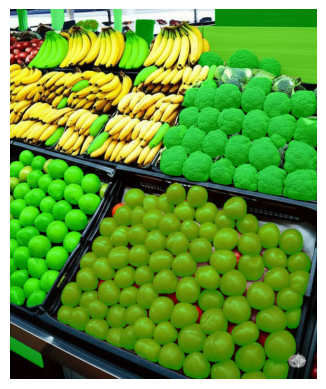

In [23]:
draw_image_segmentation(results_2, index)

In [24]:
dic_ind_1, xyxy = get_index_detection(results)

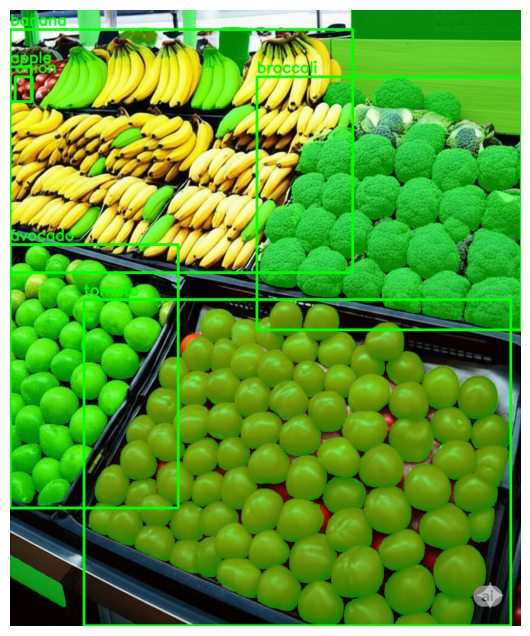

In [25]:
classes = ["banana","tomato","broccoli","onion","apple","avocado"]
img_path = "../Captone_AI/dataset/segmentation.png"  # <- set your path
draw_xyxy_on_image(img_path, xyxy, classes, out_path="annotated.png")


Saved banana_crop.jpg
Saved tomato_crop.jpg
Saved broccoli_crop.jpg
Saved onion_crop.jpg
Saved apple_crop.jpg
Saved avocado_crop.jpg


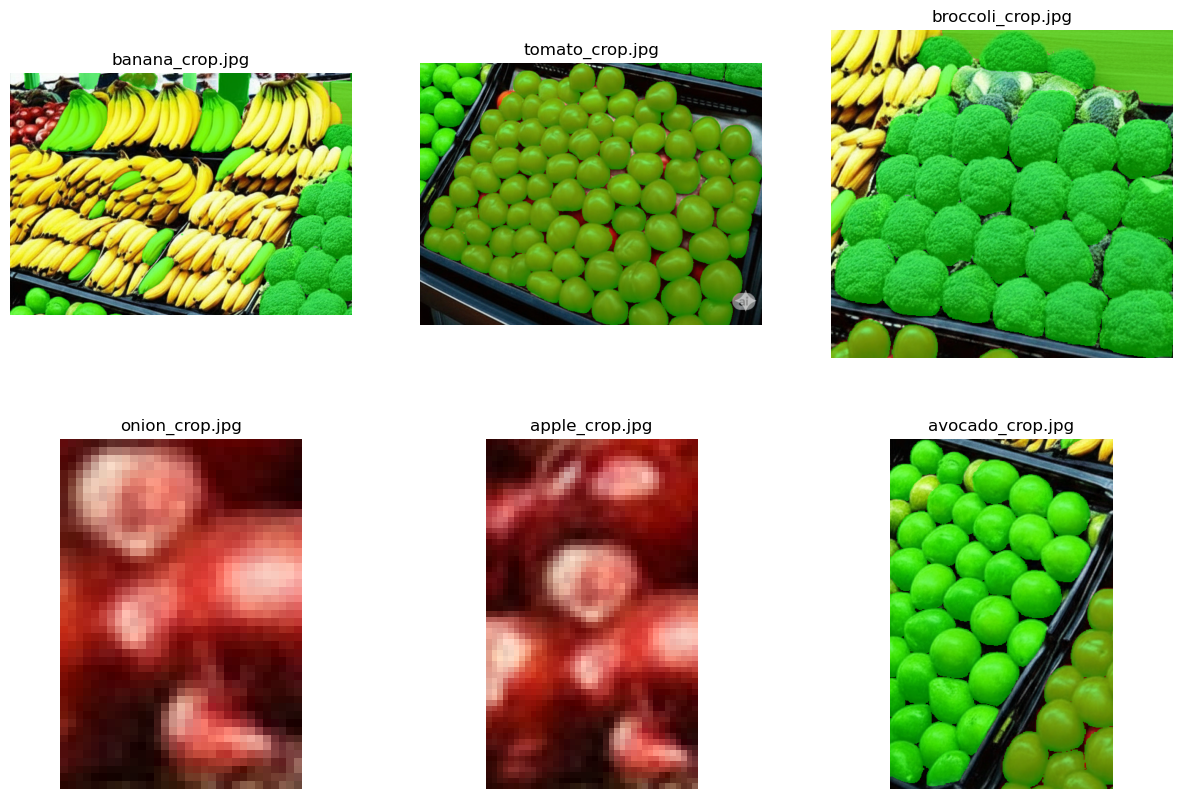

In [30]:
names, crops = crop_xyxy_regions(img_path, xyxy, classes, save_dir="crops", show=True)
